<a href="https://colab.research.google.com/github/Megs130805/machine-learning/blob/main/lab10_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install tensorflow scikit-learn lime shap matplotlib seaborn opencv-python



In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import matplotlib.pyplot as plt
import seaborn as sns



In [26]:
# Using a small subset of PlantVillage from TFDS
!pip install tensorflow-datasets
import tensorflow_datasets as tfds

# Load dataset
ds_train, ds_info = tfds.load('plant_village', split='train', with_info=True)

# Filter 3 classes (Apple_scab, Black_rot, Healthy)
selected_classes = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy']

images = []
labels = []

for example in tfds.as_numpy(ds_train):
    label_name = ds_info.features['label'].int2str(example['label'])
    if label_name in selected_classes:
        img = example['image']
        img = cv2.resize(img, (128,128))
        images.append(img)
        labels.append(label_name)

images = np.array(images)
labels = np.array(labels)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.NK7NWV_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Images shape: (2896, 128, 128, 3)
Labels shape: (2896,)


In [27]:
features = []

for img in images:
    mean_colors = cv2.mean(img)[:3]  # B, G, R
    features.append(mean_colors)

df_features = pd.DataFrame(features, columns=['B_mean','G_mean','R_mean'])
df_features['label'] = labels
df_features.head()




,B_mean,G_mean,R_mean,label
0,116.881409,135.843323,133.351196,Apple___healthy
1,100.616394,107.840027,116.669373,Apple___Apple_scab
2,106.829102,120.724243,92.549438,Apple___Black_rot
3,110.334717,120.025391,95.757996,Apple___Black_rot
4,98.468567,113.026428,129.527832,Apple___healthy


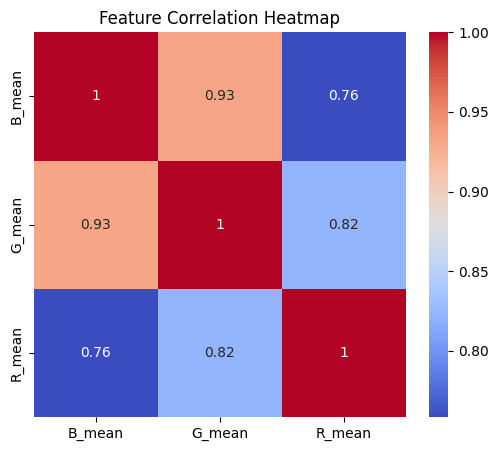

In [28]:
numeric_features = df_features[['B_mean','G_mean','R_mean']]
corr = numeric_features.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()




In [29]:
X = df_features[['B_mean','G_mean','R_mean']].values
y = LabelEncoder().fit_transform(df_features['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



In [30]:
pca_99 = PCA(n_components=0.99)
X_train_pca_99 = pca_99.fit_transform(X_train_scaled)
X_val_pca_99 = pca_99.transform(X_val_scaled)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca_99, y_train)
y_pred_99 = clf.predict(X_val_pca_99)
print("Accuracy with PCA 99% variance:", accuracy_score(y_val, y_pred_99))



Accuracy with PCA 99% variance: 0.7482758620689656


In [31]:
pca_95 = PCA(n_components=0.95)
X_train_pca_95 = pca_95.fit_transform(X_train_scaled)
X_val_pca_95 = pca_95.transform(X_val_scaled)

clf.fit(X_train_pca_95, y_train)
y_pred_95 = clf.predict(X_val_pca_95)
print("Accuracy with PCA 95% variance:", accuracy_score(y_val, y_pred_95))


Accuracy with PCA 95% variance: 0.6293103448275862


In [32]:
lr = LogisticRegression(max_iter=1000)
sfs = SequentialFeatureSelector(lr, n_features_to_select=2, direction='forward')
sfs.fit(X_train_scaled, y_train)

X_train_sfs = sfs.transform(X_train_scaled)
X_val_sfs = sfs.transform(X_val_scaled)

lr.fit(X_train_sfs, y_train)
y_sfs_pred = lr.predict(X_val_sfs)
print("Accuracy with Sequential Feature Selection:", accuracy_score(y_val, y_sfs_pred))


Accuracy with Sequential Feature Selection: 0.6551724137931034


In [34]:
# Train on original 3 features
clf_original = RandomForestClassifier(n_estimators=100, random_state=42)
clf_original.fit(X_train_scaled, y_train)

# Create LIME explainer
explainer = LimeTabularExplainer(
    X_train_scaled,
    mode='classification',
    feature_names=['B_mean','G_mean','R_mean'],
    class_names=np.unique(labels)
)

# Explain the first validation instance
exp = explainer.explain_instance(X_val_scaled[0], clf_original.predict_proba, num_features=3)
exp.show_in_notebook(show_table=True)


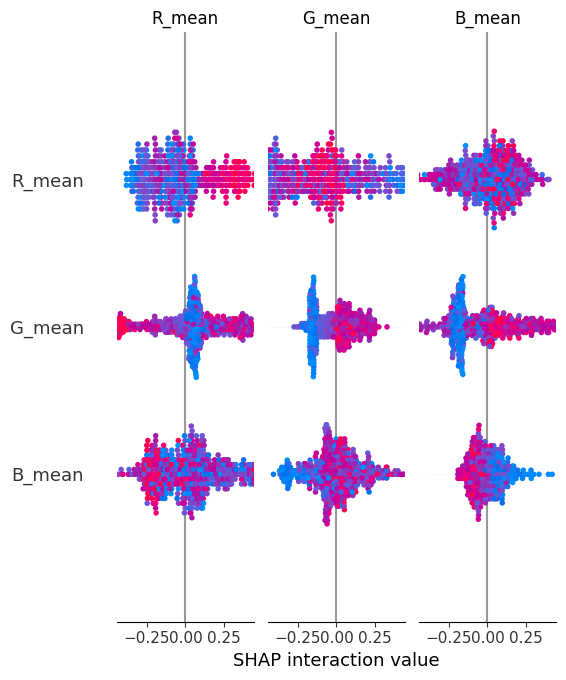

In [35]:
# Use the same model trained on original features
shap_explainer = shap.TreeExplainer(clf_original)
shap_values = shap_explainer.shap_values(X_val_scaled)

# Summary plot
shap.summary_plot(shap_values, X_val_scaled, feature_names=['B_mean','G_mean','R_mean'])
